# Leave-redshift-out

In [28]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import sys
import matplotlib.pyplot as plt

from forestflow.model_p3d_arinyo import ArinyoModel
from forestflow.archive import GadgetArchive3D
from forestflow.P3D_cINN import P3DEmulator
from forestflow.plots.l1O_p3d import plot_p3d_LzO
from forestflow.plots.l1O_p1d import plot_p1d_LzO

from matplotlib import rcParams

rcParams["mathtext.fontset"] = "stix"
rcParams["font.family"] = "STIXGeneral"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# from forestflow.model_p3d_arinyo import ArinyoModel
# from forestflow import model_p3d_arinyo
# from forestflow.archive import GadgetArchive3D
# from forestflow.P3D_cINN import P3DEmulator
# from forestflow.likelihood import Likelihood
# from forestflow.utils import sigma68
# from forestflow.plots_v0 import plot_p1d_LzO, plot_p3d_LzO

In [4]:

# import matplotlib.pyplot as plt
# import matplotlib

# font = {"size": 22}
# matplotlib.rc("font", **font)
# plt.rc("text", usetex=False)
# matplotlib.rcParams["mathtext.fontset"] = "cm"
# matplotlib.rc("xtick", labelsize=15)
# matplotlib.rc("ytick", labelsize=15)


## DEFINE FUNCTIONS

In [5]:
def ls_level(folder, nlevels):
    for ii in range(nlevels):
        folder = os.path.dirname(folder)
    folder += "/"
    return folder


path_program = ls_level(os.getcwd(), 1)
print(path_program)
sys.path.append(path_program)

/home/jchaves/Proyectos/projects/lya/ForestFlow/


# LOAD DATA

In [6]:
%%time
folder_interp = path_program + "/data/plin_interp/"
folder_lya_data = path_program + "/data/best_arinyo/"

Archive3D = GadgetArchive3D(
    base_folder=path_program,
    folder_data=folder_lya_data,
    force_recompute_plin=False,
    average="both",
)
print(len(Archive3D.training_data))

1650
CPU times: user 12.8 s, sys: 401 ms, total: 13.2 s
Wall time: 13.2 s


In [7]:
Nrealizations = 100
Nsim = 30

k_Mpc = Archive3D.training_data[0]["k3d_Mpc"]
mu = Archive3D.training_data[0]["mu3d"]

k_mask = (k_Mpc < 4) & (k_Mpc > 0)

k_Mpc = k_Mpc[k_mask]
mu = mu[k_mask]

k_p1d_Mpc = Archive3D.training_data[0]["k_Mpc"]
k1d_mask = (k_p1d_Mpc < 5) & (k_p1d_Mpc > 0)
k_p1d_Mpc = k_p1d_Mpc[k1d_mask]
norm = k_p1d_Mpc / np.pi

## LEAVE REDSHIFT OUT TEST

#### Define redshifts to test


In [40]:
z_test = [3.5, 2.5]

In [41]:
p3ds_pred = np.zeros(shape=(Nsim, len(z_test), k_Mpc.shape[0]))
p1ds_pred = np.zeros(shape=(Nsim, len(z_test), k_p1d_Mpc.shape[0]))

p3ds_arinyo = np.zeros(shape=(Nsim, len(z_test), k_Mpc.shape[0]))
p1ds_arinyo = np.zeros(shape=(Nsim, len(z_test), k_p1d_Mpc.shape[0]))

p3ds_sims = np.zeros(shape=(Nsim, len(z_test), k_Mpc.shape[0]))
p1ds_sims = np.zeros(shape=(Nsim, len(z_test), k_p1d_Mpc.shape[0]))

for iz, zdrop in enumerate(z_test):
    print(f"Dropping redshift {zdrop}")

    training_data = [d for d in Archive3D.training_data if d["z"] != zdrop]

    # p3d_emu = P3DEmulator(
    #     training_data,
    #     Archive3D.emu_params,
    #     nepochs=300,
    #     lr=0.001,  # 0.005
    #     batch_size=20,
    #     step_size=200,
    #     gamma=0.1,
    #     weight_decay=0,
    #     adamw=True,
    #     nLayers_inn=12,  # 15
    #     Archive=Archive3D,
    #     use_chains=False,
    #     chain_samp=100_000,
    #     folder_chains="/data/desi/scratch/jchavesm/p3d_fits_new/",
    # )
    
    p3d_emu = P3DEmulator(
        training_data,
        Archive3D.emu_params,
        nepochs=1,
        lr=0.001,  # 0.005
        batch_size=20,
        step_size=200,
        gamma=0.1,
        weight_decay=0,
        adamw=True,
        nLayers_inn=12,  # 15
        Archive=Archive3D,
        model_path=f"../data/emulator_models/mpg_dropz{zdrop}.pt",
    )

    for s in range(Nsim):
        # load arinyo module
        flag = f"Plin_interp_sim{s}.npy"
        file_plin_inter = folder_interp + flag
        pk_interp = np.load(file_plin_inter, allow_pickle=True).all()
        model_Arinyo = ArinyoModel(camb_pk_interp=pk_interp)

        # define test sim
        dict_sim = [
            d
            for d in Archive3D.training_data
            if d["z"] == zdrop
            and d["sim_label"] == f"mpg_{s}"
            and d["val_scaling"] == 1
        ]

        # p1d from sim
        p1d_sim, p1d_k = p3d_emu.get_p1d_sim(dict_sim)

        # p3d from sim
        p3d_sim = dict_sim[0]["p3d_Mpc"][p3d_emu.k_mask]
        p3d_sim = np.array(p3d_sim)

        p1ds_sims[s, iz] = p1d_sim
        p3ds_sims[s, iz] = p3d_sim

        # load BF Arinyo and estimated the p3d and p1d from BF arinyo parameters
        out = p3d_emu.predict_P3D_Mpc(
            sim_label=f"mpg_{s}", 
            z=zdrop, 
            emu_params=dict_sim[0],
            kpar_Mpc = k_p1d_Mpc
        )
        # t_keys(['coeffs_Arinyo', 'Plin', 'p3d_cov', 'p3d', 'p1d', 'p1d_cov'])
        BF_arinyo = dict_sim[0]["Arinyo_minin"]

        p3ds_arinyo[s, iz] = model_Arinyo.P3D_Mpc(zdrop, k_Mpc, mu, BF_arinyo)
        p1ds_arinyo[s, iz] = model_Arinyo.P1D_Mpc(zdrop, k_p1d_Mpc, parameters=BF_arinyo) * norm
        
        p3ds_pred[s, iz] = out['p3d']
        p1ds_pred[s, iz] = out['p1d'] * norm

    print(
        "Mean fractional error P3D pred to Arinyo",
        ((p3ds_pred[:, iz] / p3ds_arinyo[:, iz] - 1) * 100).mean(),
    )
    print(
        "Std fractional error P3D pre to Arinyo",
        ((p3ds_pred[:, iz] / p3ds_arinyo[:, iz] - 1) * 100).std(),
    )

    print(
        "Mean fractional error P3D Arinyo model",
        ((p3ds_arinyo[:, iz] / p3ds_sims[:, iz] - 1) * 100).mean(),
    )
    print(
        "Std fractional error P3D Arinyo model",
        ((p3ds_arinyo[:, iz] / p3ds_sims[:, iz] - 1) * 100).std(),
    )

    print(
        "Mean fractional error P3D pred to sim",
        ((p3ds_pred[:, iz] / p3ds_sims[:, iz] - 1) * 100).mean(),
    )
    print(
        "Std fractional error P3D pred to sim",
        ((p3ds_pred[:, iz] / p3ds_sims[:, iz] - 1) * 100).std(),
    )

    print(
        "Mean fractional error P1D pred to Arinyo",
        ((p1ds_pred[:, iz] / p1ds_arinyo[:, iz] - 1) * 100).mean(),
    )
    print(
        "Std fractional error P1D pred to Arinyo",
        ((p1ds_pred[:, iz] / p1ds_arinyo[:, iz] - 1) * 100).std(),
    )

    print(
        "Mean fractional error P1D Arinyo model",
        ((p1ds_arinyo[:, iz] / p1ds_sims[:, iz] - 1) * 100).mean(),
    )
    print(
        "Std fractional error P1D Arinyo model",
        ((p1ds_arinyo[:, iz] / p1ds_sims[:, iz] - 1) * 100).std(),
    )

    print(
        "Mean fractional error P1D pred to sim",
        ((p1ds_pred[:, iz] / p1ds_sims[:, iz] - 1) * 100).mean(),
    )
    print(
        "Std fractional error P1D pred to sim",
        ((p1ds_pred[:, iz] / p1ds_sims[:, iz] - 1) * 100).std(),
    )

Dropping redshift 3.5


/home/jchaves/Proyectos/projects/lya/ForestFlow/forestflow/P3D_cINN.py:580: UserWarning: Loading a pre-trained emulator
  warn("Loading a pre-trained emulator")
/home/jchaves/Proyectos/projects/lya/ForestFlow/forestflow/P3D_cINN.py:443: UserWarning: Covariance matrix returned for p3d_arinyo.reshape(-1)
  warn("Covariance matrix returned for p3d_arinyo.reshape(-1)")


Mean fractional error P3D pred to Arinyo 1.8562377619261947
Std fractional error P3D pre to Arinyo 6.315283207207092
Mean fractional error P3D Arinyo model -1.3041073585254628
Std fractional error P3D Arinyo model 8.128924116661667
Mean fractional error P3D pred to sim 0.26746404167793497
Std fractional error P3D pred to sim 7.4126754715794245
Mean fractional error P1D pred to Arinyo -0.4238756878796372
Std fractional error P1D pred to Arinyo 1.6159486687250424
Mean fractional error P1D Arinyo model 0.21342681932643595
Std fractional error P1D Arinyo model 1.6739104099114004
Mean fractional error P1D pred to sim -0.23367071897296046
Std fractional error P1D pred to sim 0.9864776016459069
Dropping redshift 2.5
Mean fractional error P3D pred to Arinyo 2.421037902213572
Std fractional error P3D pre to Arinyo 5.933569440300202
Mean fractional error P3D Arinyo model -1.2468418681484412
Std fractional error P3D Arinyo model 7.794922454651653
Mean fractional error P3D pred to sim 0.8371572604

## PLOTTING

In [42]:
folder = "/home/jchaves/Proyectos/projects/lya/data/forestflow/figures/"
z_use = np.array(z_test)
z_use

array([3.5, 2.5])

#### P3D

In [43]:
fractional_errors_arinyo = (p3ds_pred / p3ds_arinyo -1)
fractional_errors_sims = (p3ds_pred / p3ds_sims -1)
fractional_errors_bench = (p3ds_arinyo / p3ds_sims -1)

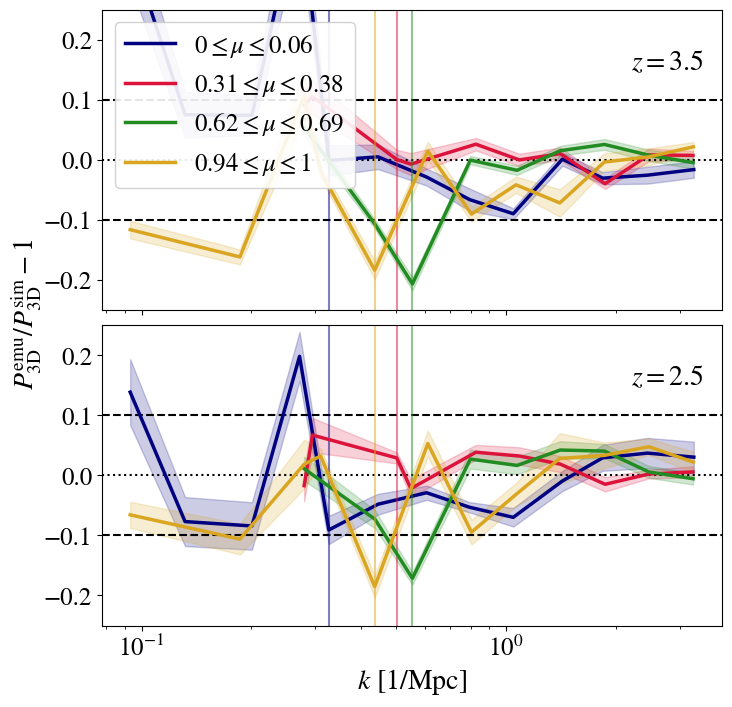

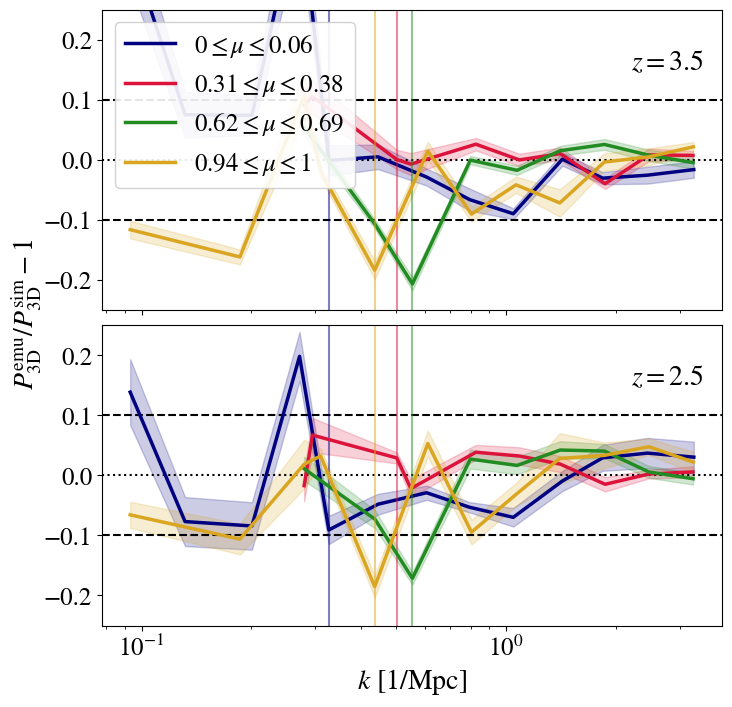

In [44]:
# plot_p3d_LzO(Archive3D, z_use, fractional_errors_sims)
plot_p3d_LzO(Archive3D, z_use, fractional_errors_sims, savename=folder+"l1O/l1O_z_P3D.png");
plot_p3d_LzO(Archive3D, z_use, fractional_errors_sims, savename=folder+"l1O/l1O_z_P3D.pdf");

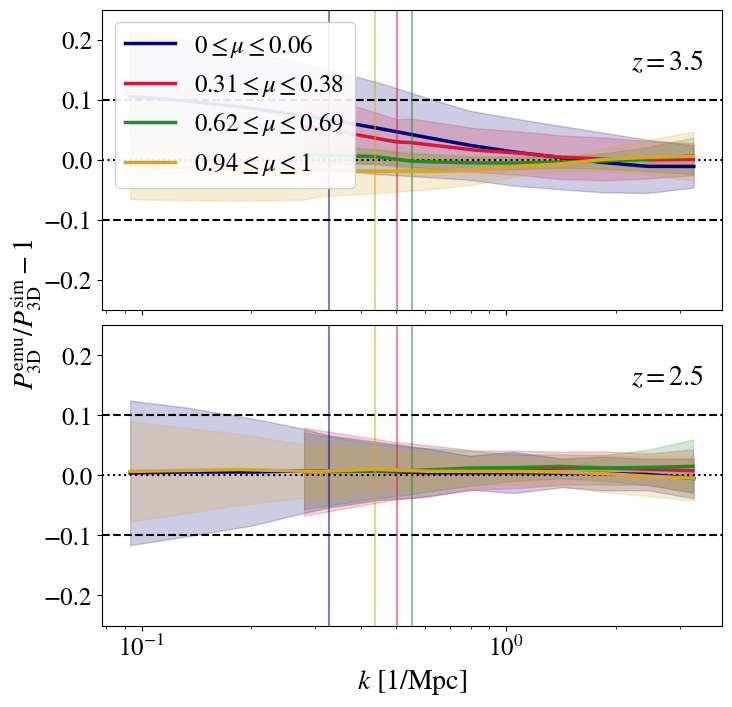

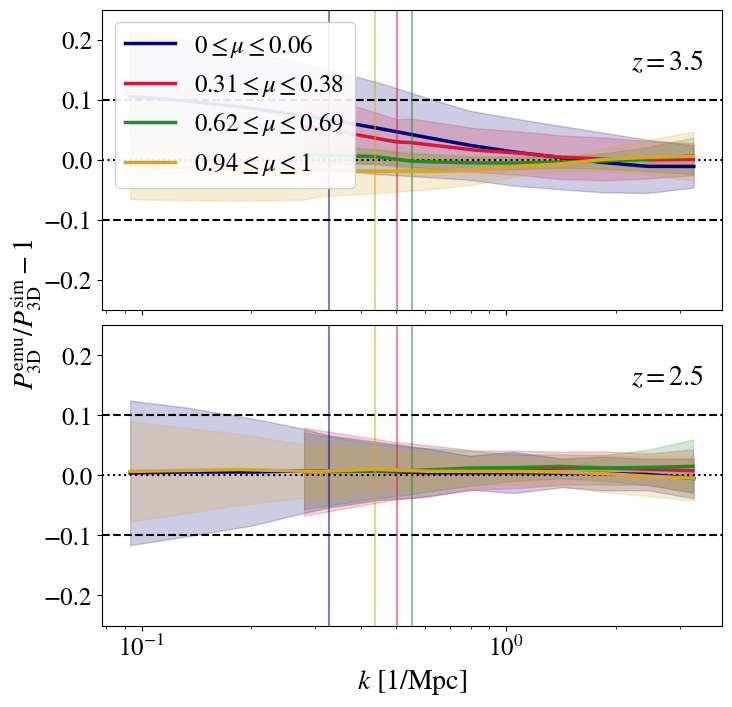

In [45]:
plot_p3d_LzO(Archive3D, z_use, fractional_errors_arinyo, savename=folder+"l1O/l1O_z_P3D_smooth.png");
plot_p3d_LzO(Archive3D, z_use, fractional_errors_arinyo, savename=folder+"l1O/l1O_z_P3D_smooth.pdf");

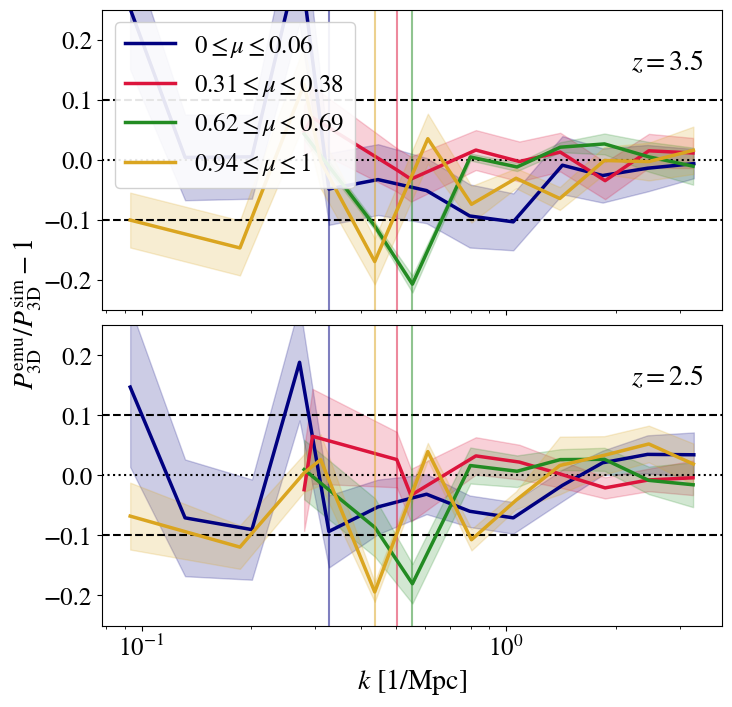

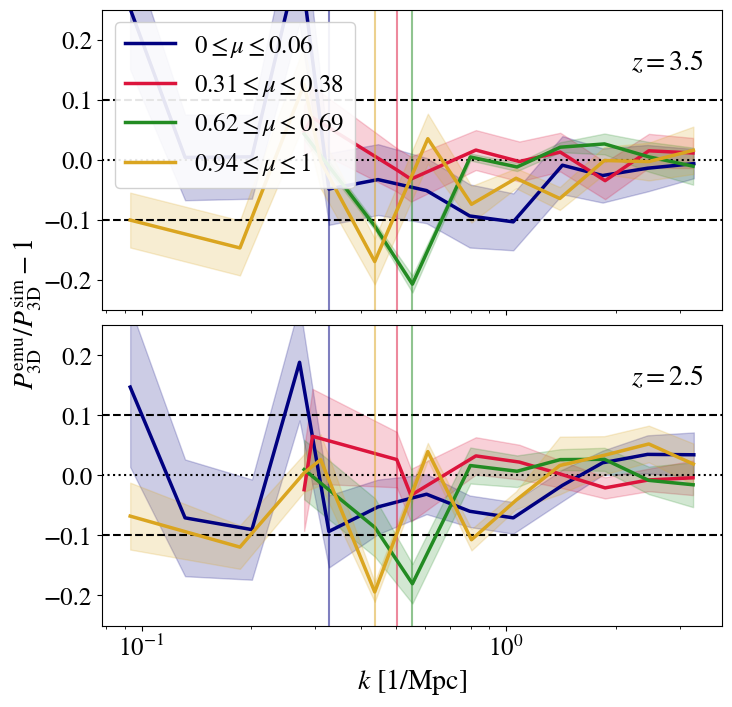

In [46]:
plot_p3d_LzO(Archive3D, z_use, fractional_errors_bench, savename=folder+"fit/fit_z_P3D.png")
plot_p3d_LzO(Archive3D, z_use, fractional_errors_bench, savename=folder+"fit/fit_z_P3D.pdf")

#### P1D

In [47]:
fractional_errors_arinyo_p1d = (p1ds_pred / p1ds_arinyo - 1)
fractional_errors_sims_p1d = (p1ds_pred / p1ds_sims - 1)
fractional_errors_bench_p1d = (p1ds_arinyo / p1ds_sims - 1)

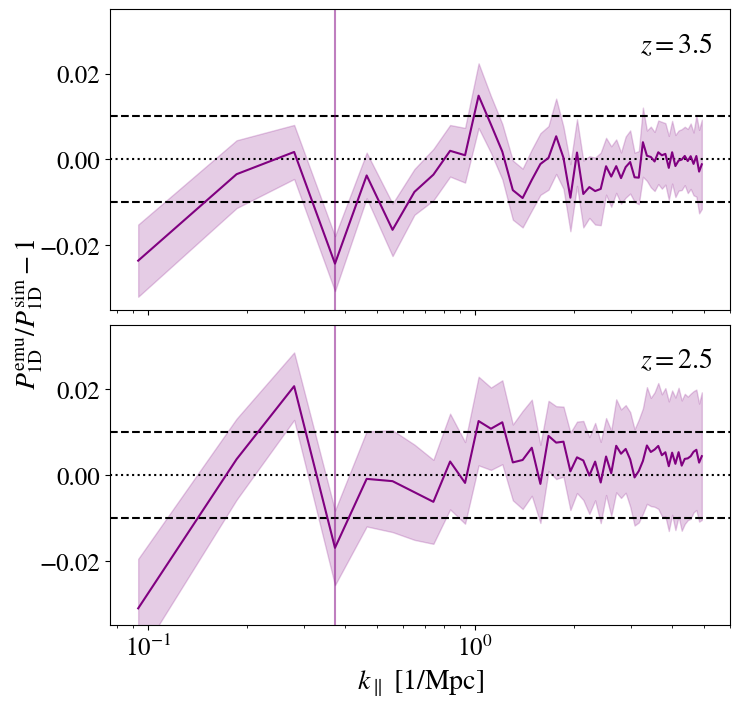

In [51]:
plot_p1d_LzO(Archive3D, z_use, fractional_errors_sims_p1d)

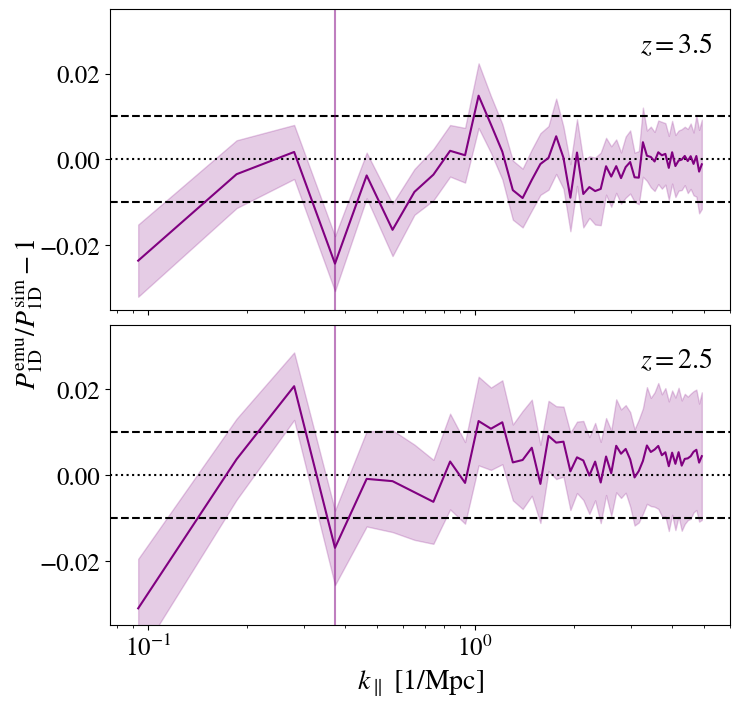

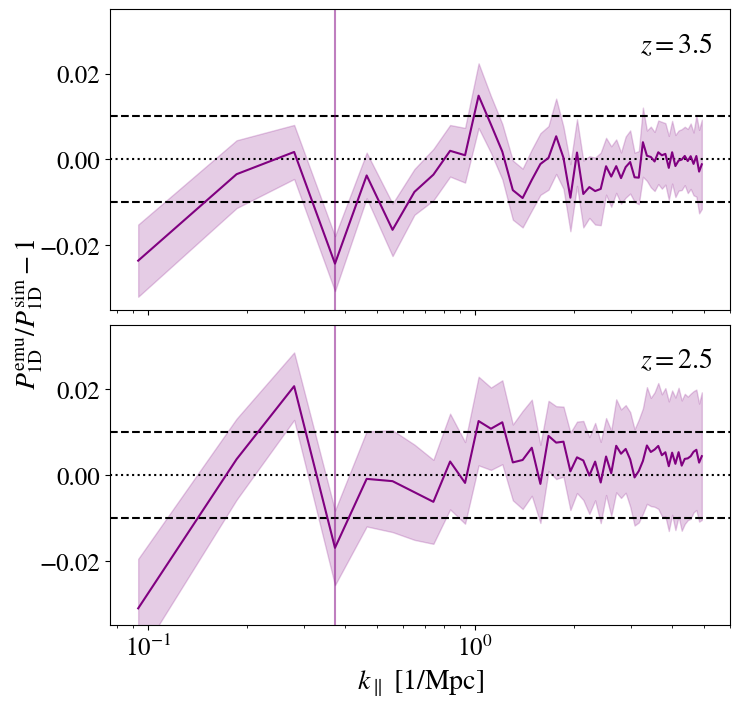

In [52]:
# plot_p1d_L1O(Archive3D, z_use, fractional_errors_sims_p1d)
plot_p1d_LzO(Archive3D, z_use, fractional_errors_sims_p1d, savename=folder+"l1O/l1O_z_P1D.png")
plot_p1d_LzO(Archive3D, z_use, fractional_errors_sims_p1d, savename=folder+"l1O/l1O_z_P1D.pdf")

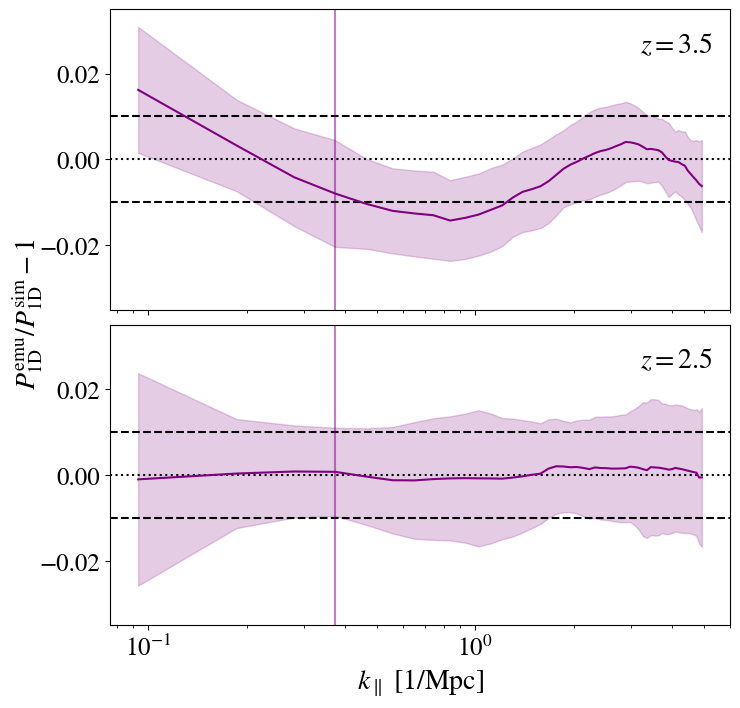

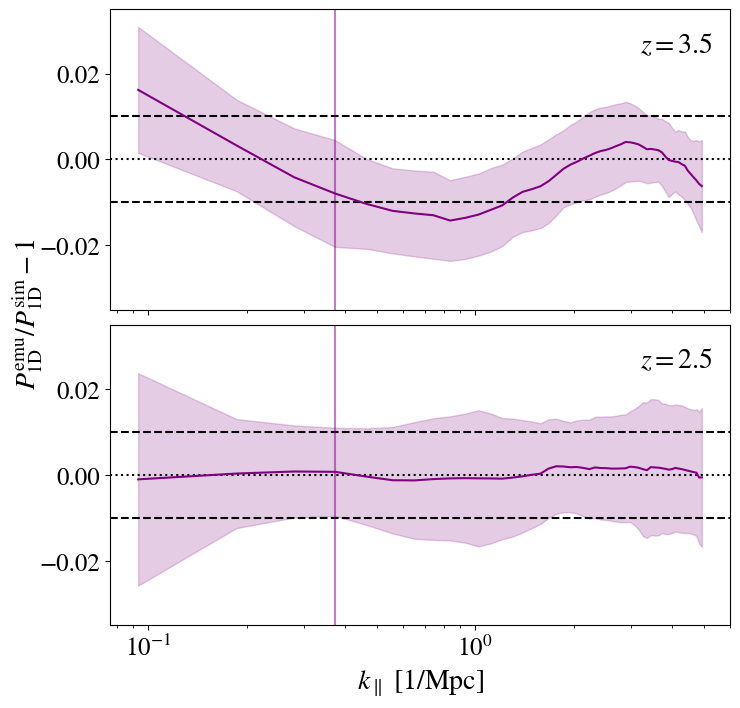

In [53]:
# plot_p1d_L1O(Archive3D, z_use, fractional_errors_arinyo_p1d)
plot_p1d_LzO(Archive3D, z_use, fractional_errors_arinyo_p1d, savename=folder+"l1O/l1O_z_P1D_smooth.pdf")
plot_p1d_LzO(Archive3D, z_use, fractional_errors_arinyo_p1d, savename=folder+"l1O/l1O_z_P1D_smooth.png")

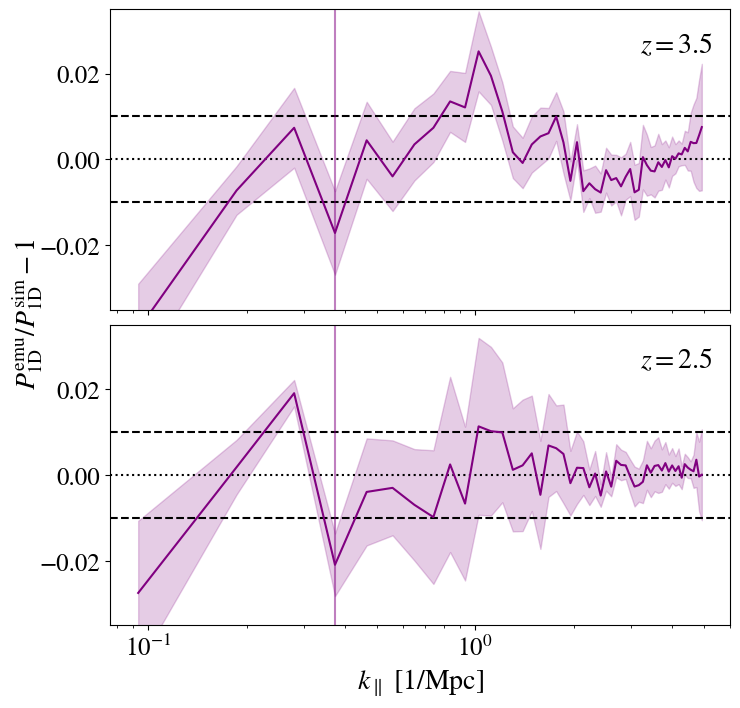

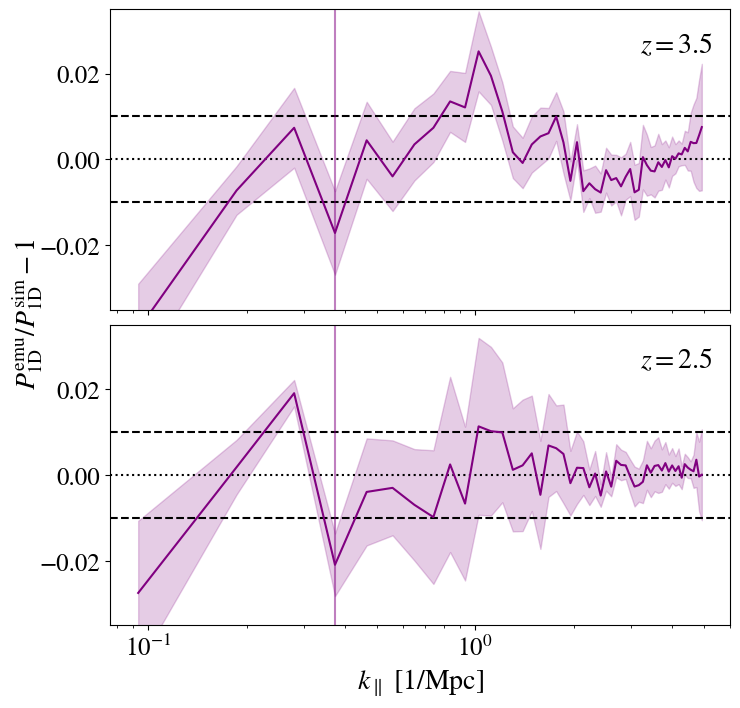

In [54]:
# plot_p1d_L1O(Archive3D, z_use, fractional_errors_bench_p1d)
plot_p1d_LzO(Archive3D, z_use, fractional_errors_bench_p1d, savename=folder+"fit/fit_z_P1D.png")
plot_p1d_LzO(Archive3D, z_use, fractional_errors_bench_p1d, savename=folder+"fit/fit_z_P1D.pdf")